# Calculate crop statistics 

## Background

Crop type maps provide information on the distribution of different crops and can be used to generate crop area statistics, contributing to the understanding of agricultural production.

## Description

This notebook demonstrates how to calculate crop area statistics using the crop type maps and input administration boundaries vector file.
Results are inspected and saved into tables.


## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages

In [1]:
import os
import pickle
import json

import datacube
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rioxarray
import xarray as xr
from deafrica_tools.spatial import xr_rasterize

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


## Load admin boundaries and crop map

We will load the data using coordinate reference system `EPSG:6933` for area calculation. The reference system uses units in meter.

In [2]:
output_crs = "EPSG:6933"

Geometries for regions where crop areas are to be calculated are loaded in a GeoPandas Dataframe. For calculating crop areas within the entire country, one geometry for the country should be provided. For calculating crop areas within provinces, a list of geometries for the provinces should be provided.

> For testing, we caculate crop areas for level 3 admin regions within a district where a crop type map has been generated.

If no district name is provided, area statistics are calculated for level 1 provinces. However, this would only work if the national crop type map has been produced.

In [3]:
# select the district name for which a crop map is available
district_name = "Matsinho 2" 
crop_map_path = "Results/Map"

mozambique_admins = gpd.read_file("Data/Mozambique_admin_gadm_level3.gpkg")
if district_name is None:
    area_of_interest_gdf = mozambique_admins.dissolve(by="GID_0")
    # Define the column name that is used to identify each area.
    name_col = "NAME_0"
    # Area name used to find the crop map 
    area_name = "Mozambique"
else:
    area_of_interest_gdf = mozambique_admins[mozambique_admins["NAME_3"]==district_name]
    # Define the column name that is used to identify each area.
    name_col = "NAME_3"
    # Area name used to find the crop map
    area_name = district_name.replace(' ','_')

area_of_interest_gdf.reset_index(inplace=True)
area_of_interest_gdf.head()

,index,UID,GID_0,NAME_0,VARNAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,ISO_1,...,GOVERNEDBY,SOVEREIGN,DISPUTEDBY,REGION,VARREGION,COUNTRY,CONTINENT,SUBCONT,layer,geometry
0,135,210773,MOZ,Mozambique,,MOZ.4_1,Manica,,,MZ-B,...,,Mozambique,,,,Mozambique,Africa,,gadm_africa,"MULTIPOLYGON (((33.49312 -19.20316, 33.47890 -..."


In [4]:
area_of_interest_gdf.explore(
    tiles = "https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}", 
    attr ='Imagery @2022 Landsat/Copernicus, Map data @2022 Google',
    popup=True,
    cmap='viridis',
    style_kwds=dict(color= 'red', fillOpacity= 0, weight= 3),
    )

### Load the corresponding crop type map

In [5]:
crop_type_path= f"{crop_map_path}/{area_name}_croptype_prediction.tif"
da_crop_type=rioxarray.open_rasterio(crop_type_path, chunks={'x':2000, 'y':2000}).squeeze()

### Load the crop class labels dictionary

In [6]:
# Dictionary with class labels from previous step
labels_path = "Results/Model/class_labels.json"

# Read the class label dictionary
with open(labels_path, "r") as json_file:
    labels_dict = json.load(json_file)

## Calculate crop areas

Crop areas are calculated by counting the number of pixels classified as each crop type.

For each area, we make a mask using its geometry and count the pixels labeled as each crop type in the area mask.

> Each Sentinel-2 pixel cover 10 by 10 meters on the ground.

In [7]:
gdf_new=area_of_interest_gdf[[name_col, "geometry"]].copy()
for index, district in area_of_interest_gdf.iterrows():

    print(f"Processing polygon {index}")
    #area_of_interest_gdf.loc[index,'ID']=index
    print(area_of_interest_gdf.loc[index][name_col])
    
    # Rasterize polygon
    district_mask = xr_rasterize(
        gdf=area_of_interest_gdf.loc[[index]],
        da=da_crop_type,
        transform=da_crop_type.geobox.transform,
        crs=output_crs,
    )
    area_cols = []
    for class_name, class_value in labels_dict.items():
        # convert pixel count to hectare; each pixel is 10 m by 10 m
        crop_type_mask = da_crop_type.where(district_mask, da_crop_type.attrs['_FillValue'])==class_value
        crop_type_area=np.sum(crop_type_mask).compute()/100.0
        attr_name=class_name+"_area_hectare"
        area_cols.append(attr_name)
        gdf_new.loc[index, attr_name] = crop_type_area.data
        print('Area (hectare) for {} ({}): {}'.format(class_name, class_value, crop_type_area.data))

Processing polygon 0
Matsinho 2
Area (hectare) for Maize (0): 7397.05
Area (hectare) for Others (1): 3162.14
Area (hectare) for Sesame (2): 2164.71
Area (hectare) for Soy (3): 0.09


We then calculate the total cropped area and the porportion of each crop type.

In [8]:
# calculate total crop area
total_area_attr = "Crop_area_hectare"
total_area = gdf_new[area_cols].sum(axis=1)
gdf_new[total_area_attr] = total_area

# calculate percentage of different crop types
for class_name, class_value in labels_dict.items():
    gdf_new[class_name+"_area_precent"] = gdf_new[class_name+"_area_hectare"]*100/gdf_new[total_area_attr]

In [9]:
gdf_new

,NAME_3,geometry,Maize_area_hectare,Others_area_hectare,Sesame_area_hectare,Soy_area_hectare,Crop_area_hectare,Maize_area_precent,Others_area_precent,Sesame_area_precent,Soy_area_precent
0,Matsinho 2,"MULTIPOLYGON (((33.49312 -19.20316, 33.47890 -...",7397.05,3162.14,2164.71,0.09,12723.99,58.134673,24.851796,17.012824,0.000707


## Plot crop areas

We can inspect the crop type areas calculated as a table or plot the areas as a bar chart.

In [10]:
gdf_new[area_cols].set_index(gdf_new[name_col]).round()

,Maize_area_hectare,Others_area_hectare,Sesame_area_hectare,Soy_area_hectare
NAME_3,,,,
Matsinho 2,7397.0,3162.0,2165.0,0.0


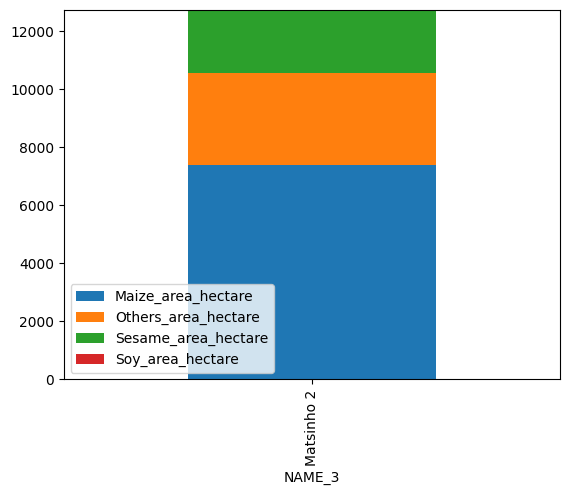

In [11]:
gdf_new[area_cols].set_index(gdf_new[name_col]).plot.bar(stacked=True);

And we can sum the areas for each crop type.

In [12]:
gdf_new[area_cols].sum().round()

Maize_area_hectare     7397.0
Others_area_hectare    3162.0
Sesame_area_hectare    2165.0
Soy_area_hectare          0.0
dtype: float64

## Save the results to tables

In [13]:
# Set results path
output_folder = "Results/Crop_stats"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [14]:
# with geometries
gdf_new.round(2).to_file(os.path.join(output_folder, f"{area_name}_crop_areas.geojson"))

In [15]:
# convert to CSV by dropping geometry
df = pd.DataFrame(gdf_new.round(2).drop(columns='geometry'))

df.to_csv(os.path.join(output_folder, f"{area_name}_crop_areas.csv"))